# HW3: Where is the Röstigraben?

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium

## Data loading and preparation

A first glance at the data gives us useful information:
* `'Nicht zuteilbar - NA'` => values not classifiable
* `'data not included in P3'` => missing values

Then we can import the data and only keep the relevant columns which are:
* `'University'`
* `'Approved Amount'`

By doing some data wrangling, we observed that out of 76 possible values for `'University'`, a few of them are useless because they cannot help in classifying by Cantons. And that one of the university is located in Italy. So we choose to remove all these rows.  
We also prepared the 26 cantons in a csv file that we can easily load to proceed further.

In [2]:
na = ['Nicht zuteilbar - NA',       # Not classifiable
      'data not included in P3']    # Missing value
df = pd.read_csv('data/P3_GrantExport.csv', delimiter=';', na_values=na, usecols=[7,13])
# Universities not classable or not within Switzerland:
no_chance = ['NPO (Biblioth., Museen, Verwalt.) - NPO',
             'Firmen/Privatwirtschaft - FP',
             'Weitere Institute - FINST',
             'Weitere Spitäler - ASPIT',
             'Istituto Svizzero di Roma - ISR']
df = df.replace(no_chance, np.NAN)
df = df[df['Approved Amount'].notnull() & df['University'].notnull()] # Retain only relevant info
# The 26 swiss cantons:
cantons = pd.read_csv('data/cantons_codes.csv', header=None, names=['Name'])
unis = df['University'].drop_duplicates().dropna()

Now that we obtained all the relevant information, we can search for the addresses (geolocations) using the Google Places API. The idea is to parse all the different universities and store every finding in a dict then save it to the disk. At the end we had to manually add 6 entries which were not solved by the API.

In [3]:
# Using Google to retrieve missing canton and all locations:
# pip install python-google-places
from googleplaces import GooglePlaces, types, lang
from keys import GOOGLE_KEY
google_places = GooglePlaces(GOOGLE_KEY)

def search_google(place):
    place.get_details()
    location = place.geo_location
    for address in place.details['address_components']:
        canton = address['short_name']
        if canton in cantons.values:
            return canton, location
    return None, location

locations = {}
try:
    locations = pd.read_json('data/unis.json').to_dict()
except:
    for name in unis.values:
        if name in locations.keys():
            continue
        r = google_places.text_search(query=name.split(' - ')[0]+' Schweiz')
        if r and r.places:
            canton, location = search_google(r.places[0]) # 1st result from query
            locations.update({name:{'canton':canton,'location':location}})
    manual = {
    'Physikal.-Meteorolog. Observatorium Davos - PMOD':{'canton':'GR', 'location':{'lat':46.814241, 'lng':9.844508}},
    'Forschungsinstitut für Opthalmologie - IRO':{'canton':'VS', 'location':{'lat':46.233131, 'lng':7.383104}},
    'Swiss Institute of Bioinformatics - SIB':{'canton':'VD', 'location':{'lat':46.519433, 'lng':6.574533}},
    'Pädag. Hochschule Tessin (Teilschule SUPSI) - ASP':{'canton':'TI', 'location':{'lat':46.023528, 'lng':8.917150}},
    'Staatsunabh. Theologische Hochschule Basel - STHB':{'canton':'BL', 'location':{'lat':47.577821, 'lng':7.650187}},
    'Forschungskommission SAGW':{'canton':'LU', 'location':{'lat':47.050179, 'lng':8.312586}}
    }
    pd.DataFrame(dict(locations,**manual)).to_json('data/unis.json')
print('{}/{} locations loaded... :)'.format(len(locations),len(unis)))

71/71 locations loaded... :)


Now we can join the cantons to the universities and update the dataframe.

In [4]:
uni_canton = pd.DataFrame([locations[uni]['canton'] for uni in df['University']], 
                          index=df.index, columns=['Canton'])
df = pd.concat([df, uni_canton], axis=1, join_axes=[df.index])

Let put everything together:
* add missing canton values to 0
* group by the cantons
* sum up the amounts.

Then display the results in a bar plot.

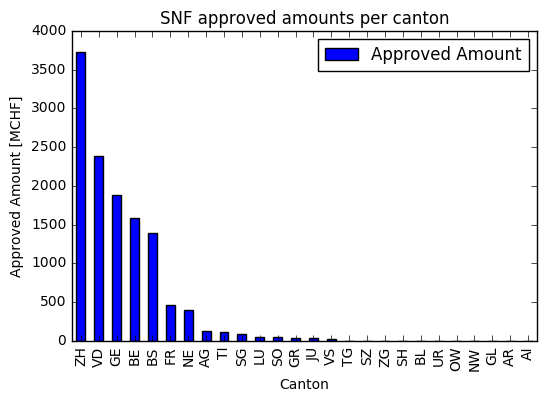

In [5]:
per_canton = df[['Canton', 'Approved Amount']].groupby('Canton').agg(sum) / 1e6 # MCHF
for canton in cantons['Name']:
    if not canton in per_canton.index:
        per_canton.loc[canton] = 0
per_canton.sort_values(by='Approved Amount', ascending=False).plot.bar()
plt.title('SNF approved amounts per canton')
plt.ylabel('Approved Amount [MCHF]')
plt.show()

## Vizualization


In [6]:
geo_path = 'data/ch-cantons.topojson.json'
data = per_canton.reset_index()
map = folium.Map(location=[46.88, 8.23],zoom_start=8)
map.choropleth(geo_path=geo_path, data_out='data1.json', data=data,
               columns=['Canton', 'Approved Amount'],
               threshold_scale=[0, 30, 120, 300, 1000, 2000],
               key_on='feature.id',
               fill_color='PuRd', fill_opacity=0.8, line_opacity=0.5,
               topojson='objects.cantons')
map.save('map.html')
map

## Bonus: Röstigraben
Let first see where the institutions are located

In [7]:
institutions_map = folium.Map(location=[46.798333, 8.231944],zoom_start=8)
for uni,v in locations.items():
    l = v['location']
    p = uni
    folium.Marker([l['lat'],l['lng']],popup=p).add_to(institutions_map)
institutions_map

This plot, crossed with the [Röstigraben map](https://en.wikipedia.org/wiki/Röstigraben#/media/File:Map_Languages_CH.png) from Wikipedia, allows to know which institutions are franch-speaking, which are german speaking.

This coefficient can be linked to:

- institutions
- cantons

Institutions would be more precise, due to the half-french cantons. However, there is only one such case (the _Fernfachhochschule Schweiz_). This is a small institute which will not influence the results.

The others would be in Fribourg, but the institutions are half-french and half-german (thus, a coefficient of 0.5 is assigned to Fribourg).

This coefficient will define the [très français](https://youtu.be/utrztHC_gQE) cantons.

In [8]:
frenchi_cantons = {
    "GE": 1,
    "VD": 1,
    "VS":1,
    "NE":1,
    "JU":1,
    "FR":0.5
}

def frenchi_canton_coefficient(canton_code):
    if canton_code not in set(cantons.Name):
        raise ValueError("Canton code is: {}".format(canton_code))
        
    return frenchi_cantons[canton_code] if canton_code in frenchi_cantons else 0

def linguistic_region(canton_code):
    coeff = frenchi_canton_coefficient(canton_code)
    
    if coeff == 0:
        return "German and Italian"
    if coeff == .5:
        return "Bilingual"
    if coeff == 1: 
        return "French"
    
    return coeff

Let split by linguistic region (and omitting Fribourg, which can't be grouped by)

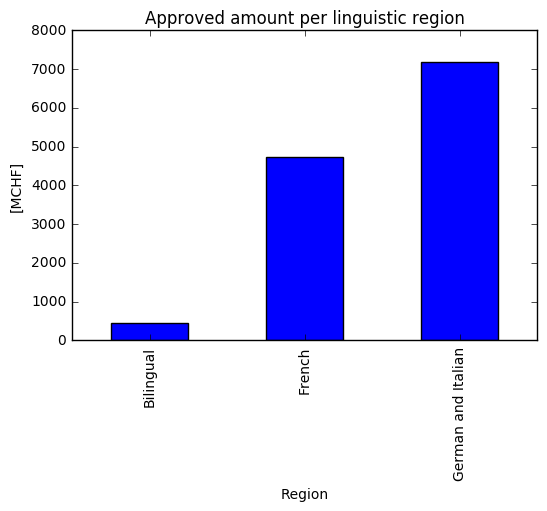

In [9]:
per_canton['linguistic_region'] = per_canton.apply(lambda x: linguistic_region(x.name), axis=1)
per_linguistic_region = per_canton.groupby('linguistic_region').sum()
per_linguistic_region['Approved Amount'].plot(kind='bar')

plt.title("Approved amount per linguistic region")
plt.xlabel("Region")
plt.ylabel("[MCHF]")

### Normalize
Comparing these values isn't very representative in the sense that regions doesn't have the same size nor the same specificities.

Normalizing this data isn't easy since a lot of different parameters have to be taken into consideration.

The choice taken here is to have the Swiss tax payer view and values are normalized by the population size of the linguistic region. The bilingual part is dropped, since it doesn't influence the inequalities between the regions.

Data are from [Wikipedia](https://fr.wikipedia.org/wiki/Suisse#Langues)

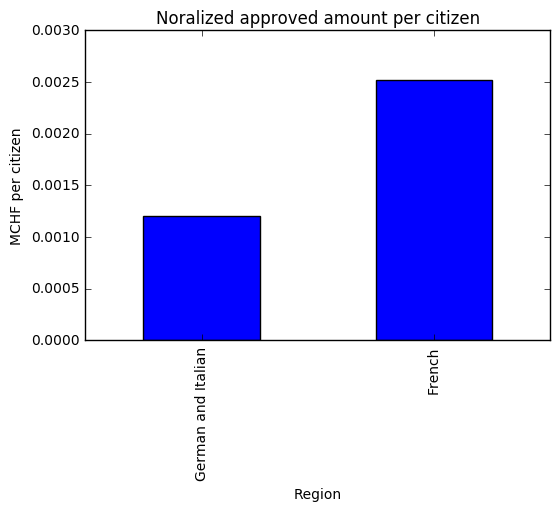

In [14]:
linguistig_region_size = {
    "German and Italian": (0.635 + 0.081) * 8341630,  # Ratio of the population * population size
    "French": 0.225 * 8341630
}

rosti_regions = per_linguistic_region.ix[['German and Italian', 'French']]
rosti_regions['normalized'] = rosti_regions.apply(lambda x: x['Approved Amount'] / linguistig_region_size[x.name], axis=1)

rosti_regions['normalized'].plot(kind='bar')
plt.title("Noralized approved amount per citizen")
plt.xlabel("Region")
plt.ylabel("MCHF per citizen")

### Conclusion
This comparison might suggest that the _SNF prefers the french part of Switzerland_. However, this result has to be taken with a grain of salt for at least these different reasons:

1. The German-speaking part might receive more alternative public-funding than the French-speaking (for example, the ETHZ might receive a lot more of public funding from the ETH Board)
2. More private funding comes to the German speaking part of Switzerland, thus less public funding is required from the SNF
3. The French-speaking region might be more dynamic than the German-speaking part

Therefore, in any case this should be interpreted as _SNF prefers the french part of Switzerland_. It has to be taken for what it is: the SNF gives more grants to the French-speaking region per citizen than to the German-speaking.